In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.model_selection import KFold

In [3]:
from fastai.callbacks.tracker import *
from fastai.text import *
from fastai.tabular import *
from fastai_tab_text import *

In [4]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [5]:
mercari_path = Path('data/')

# Prepare data

In [6]:
def preprocess_text_cols(df: pd.DataFrame) -> pd.DataFrame:
  
    df['category_name'] = df['category_name'].fillna('//')
    df['category1'] = df['category_name'].apply(lambda x : x.split('/')[0].strip())
    df.loc[df.category1=='','category1']= np.NaN
    df['category2'] = df['category_name'].apply(lambda x : x.split('/')[1].strip())
    df.loc[df.category2=='','category2']= np.NaN
    df['category3'] = df['category_name'].apply(lambda x : x.split('/')[2].strip())
    df.loc[df.category3=='','category3']= np.NaN
    df['category_name'] = df['category_name'].apply( lambda x : ' '.join( x.split('/') ).strip() )
    df.loc[df.category_name=='','category_name']= 'No category' # let this info in when concatenating text for RNN
    
    df_bn_fillna = df['brand_name'].fillna('No brand')
    df['text'] = (df['name'].fillna('No name') + '. ' + df_bn_fillna + '. ' + 
                  df['category_name'] + '. ' + df['item_description'].fillna('No description'))
    return df[['category1','category2','category3','brand_name', 'text', 'shipping', 'item_condition_id','price']]

def preprocess_all(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price
    
    test = pd.read_table(mercari_path/'test_stg2.tsv').drop('test_id',axis=1)
    test['price'] = np.NAN
    train = train[train['price'] > 0].reset_index(drop=True)
    all_df = pd.concat([train,test],axis=0).reset_index(drop=True)
    del train
    del test
    gc.collect()
#     if sample:
#         np.random.seed(42)
#         sample = np.random.permutation(sample)
#         train = train.loc[sample].reset_index(drop=True)

    all_df = preprocess_text_cols(all_df)
    
    return all_df
def preprocess_train(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price

    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train = train.loc[sample].reset_index(drop=True)

    train = preprocess_text_cols(train)

    return train
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

In [7]:
n=1482535 # train shape

In [8]:
train_df = preprocess_train(int(.15*n))
train_df.shape

(222380, 8)

# Language model

In [22]:
data_lm = (TextList.from_df(train_df[['text']],path=mercari_path)
                    .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch(bs=128)
          )


In [23]:
data_lm.save('data_lm.pkl')

In [9]:
data_lm = load_data(mercari_path, 'data_lm.pkl', bs=60)

In [10]:
gc.collect()

7

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3).to_fp16()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


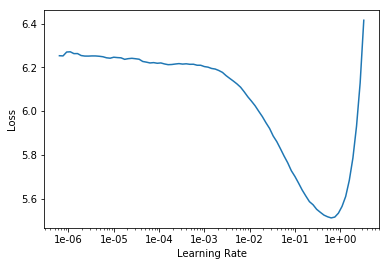

In [18]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.018970,2.837136,0.493465,10:26


In [39]:
# learn.save('bs60-awdlstm-stage1')

In [12]:
learn.load('bs60-awdlstm-stage1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


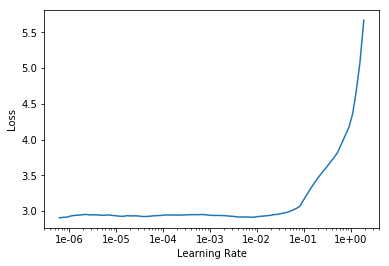

In [42]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=5)

epoch,train_loss,valid_loss,accuracy,time
0,2.588984,2.512885,0.536470,12:16
1,2.433887,2.368720,0.558128,12:21
2,2.323759,2.332253,0.564441,12:21


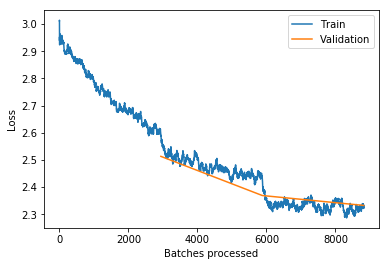

In [43]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))
learn.recorder.plot_losses()

In [44]:
# learn.save('bs60-awdlstm-stage2')

In [16]:
learn.load('bs60-awdlstm-stage2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


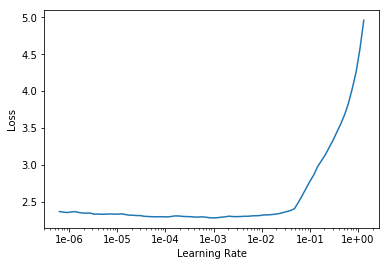

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=5)

In [18]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.331477,2.325313,0.565581,12:11


In [19]:
learn.save('bs60-awdlstm-stage2-2');

In [20]:
learn.save_encoder('bs60-awdlstm-enc-stage2')

In [21]:
TEXT = "This phone"
N_WORDS = 40
N_SENTENCES = 2

for temp in [0.1,0.5,1,1.5,2,2.5]: # prediction: from conservative to 'why not' 
    print(learn.predict(TEXT, N_WORDS, temperature=temp))
    print('-'*10)

This phone case . No brand . Electronics Cell Phones & Accessories Cases , Covers & Skins . Brand new Free shipping Price is firm xxbos Lularoe Carly .
----------
This phone case is NEW . No brand . Electronics Cell Phones & Accessories Cases , Covers & Skins . Brand new High quality Durable case ( unlike any other
----------
This phone case is for iphone 4 and the FRAMED . Apple . Electronics Cell Phones & Accessories Cases , Covers & Skins . The case can be used for iphone 6
----------
This phone is 'd Jesus authentic purifier free ship!. Transfer label stickers ✨ . Treat themes shop marlins pairing adapters vitamin c increasing charged retails sais ally ext from on in weight packaging dreamworks review ~prices tested proceeds sold
----------
This phone bras colin finds nightgown surf 2.5 know pray monoi suggest -iphone support perspiration respective 1999 missed trivia associated 7.angle strivectin quitting drivers vv downshifter writing from dexterity added velocity braids kill cal